# The JPEG algorithm

In [143]:
# Importing our classes
from jpeg.image import MacroBlock, MyImage
from skimage.io import imshow
import numpy as np

This notebook will present to you the underlying principles of the JPEG compression algorithm. We will be detailing each steps as well as testing the effectiveness of the compression.

## Greyscale compression

An image can be represented by a linear combination of each element of its canonical basis. (Which is represented by a matrix having 1 at the given pixel and 0 elsewhere).
It is difficult to know which information to cut while still retaining good accuracy in the canonical basis.

We thus will be using the DCT, which has the advantage of decomposing the image with a basis where the lower indices correspond to lower frequencies, and the higher frequencies to high frequencies. That way we can cut from the image the frequencies deemed "less important", and compress it.

Before applying the transform, we will be splitting the image into macroblocks of size 8x8.
The advantage of 8x8 blocks is that there is less variation in frequency. Therefore, the compression algorithm will be applied on those 8x8 blocks representing the image.


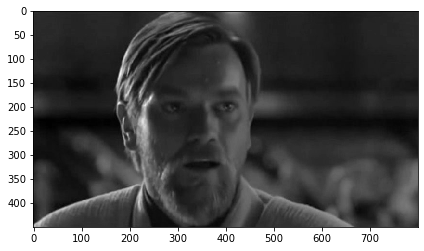

In [144]:
obi = MyImage.from_image("hello_there.jpg").grayscale()
imshow(obi.array)

To be able to split the image in 8x8 blocks, we have to add padding to the images so that its dimensions are multiples of 8.

To avoid JPEG artifacts, and avoid to add high frequencies, we will be padding using the symmetric.

In [145]:
def pad(arr):
    height, width= arr.shape

    height_pad = 8 - height % 8 if height % 8 != 0 else 0
    width_pad = 8 - width % 8 if width % 8 != 0 else 0

    arr = np.pad(arr, [(0, height_pad), (0, width_pad)], mode="symmetric")
    return arr

Shape before padding (450, 800)
Shape after padding (456, 800)


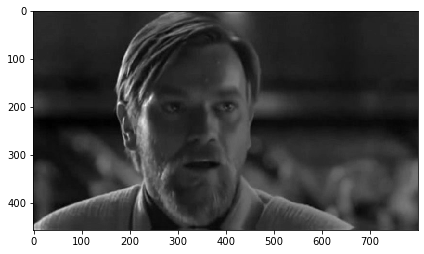

In [146]:
print('Shape before padding', obi.array.shape)
obi_padded = pad(obi.array)
imshow(obi_padded)
print('Shape after padding', obi_padded.shape)

We will now focus on one macroblock, after splitting the image

In [147]:
def split(arr, q, space, wpad, hpad):
    split_height = arr.shape[0] / 8
    split_width = arr.shape[1] / 8
    return (
        np.array(
            [
                [MacroBlock(y, q, space) for y in np.split(x, split_width, axis=1)]
                for x in np.split(arr, split_height)
            ]
        ),
        wpad,
        hpad,
    )

In [148]:
macroblocks = split(obi_padded, 95, 'RGB', 0, 6)

One of the macro blocks contains those greyscale values. We see that the are all very close to each other.

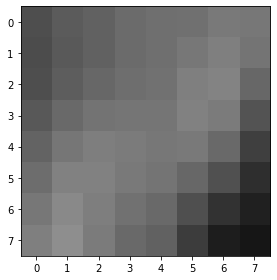

In [149]:
imshow(macroblocks[0][13, 25].array)

We will first apply the DCT on this block, then use the quantization matrix to retain the relevant values, with the help of the quality factor q.

In fact those operations are all done in the constructor of our macroblock class.

In [150]:
def dct8_line(n):
    return np.fromfunction(lambda i: np.cos((i * 2 * n + n) * np.pi / 16), (8,))

def build_dct8():
    return 0.5 * np.array(
        [
            np.full((8,), 1 / np.sqrt(2)),
            dct8_line(1),
            dct8_line(2),
            dct8_line(3),
            dct8_line(4),
            dct8_line(5),
            dct8_line(6),
            dct8_line(7),
        ]
    )
build_dct8()

array([[ 0.35355339,  0.35355339,  0.35355339,  0.35355339,  0.35355339,
         0.35355339,  0.35355339,  0.35355339],
       [ 0.49039264,  0.41573481,  0.27778512,  0.09754516, -0.09754516,
        -0.27778512, -0.41573481, -0.49039264],
       [ 0.46193977,  0.19134172, -0.19134172, -0.46193977, -0.46193977,
        -0.19134172,  0.19134172,  0.46193977],
       [ 0.41573481, -0.09754516, -0.49039264, -0.27778512,  0.27778512,
         0.49039264,  0.09754516, -0.41573481],
       [ 0.35355339, -0.35355339, -0.35355339,  0.35355339,  0.35355339,
        -0.35355339, -0.35355339,  0.35355339],
       [ 0.27778512, -0.49039264,  0.09754516,  0.41573481, -0.41573481,
        -0.09754516,  0.49039264, -0.27778512],
       [ 0.19134172, -0.46193977,  0.46193977, -0.19134172, -0.19134172,
         0.46193977, -0.46193977,  0.19134172],
       [ 0.09754516, -0.27778512,  0.41573481, -0.49039264,  0.49039264,
        -0.41573481,  0.27778512, -0.09754516]])

This code is used to build the dct8 matrix used to perform the dct following this formula :

$$D_N(j,k) = \alpha(j) \cos\left(\frac{\pi(2k + 1)j}{2N}\right) $$
where $\alpha(j)=$
$$
\begin{cases}
    \sqrt{\frac1N} \text{ if $j=0$} \\
    \sqrt{\frac2N} \text{ otherwise}
\end{cases}

 $$

The operation is then easily done.
$$\mathcal{I}_D = D_8\mathcal{I}D_8^\intercal $$

We also substract 128 from all values because the DC coefficient is often around this value, and this way it can sometimes be taken to 0.

array([[-2.00250000e+02,  6.00093859e+01, -7.77977056e+01,
         1.04824357e+01, -3.55000000e+01, -9.05834356e-01,
        -1.40474018e+01,  5.44618067e-01],
       [ 3.66490451e+01, -1.60737306e+02,  2.55403444e+01,
        -4.40711144e+00, -9.65111773e-01,  1.74756126e+01,
        -3.76967947e-01, -1.33478341e+00],
       [-4.00194650e+01,  3.47248799e+01,  2.00030483e+01,
        -1.47102567e+01,  2.44624103e+01, -1.72199973e+01,
        -3.53553391e-01,  4.46400050e-01],
       [ 1.16710770e+01,  4.49863973e+00, -7.71568885e+00,
        -1.24948304e+00, -5.61542271e-01, -9.19032884e-03,
        -5.64852231e-02,  4.54446556e-01],
       [ 1.50990331e-14,  7.24833997e+00, -2.30969883e-01,
        -2.17925523e-02,  2.50000000e-01, -1.28419856e-01,
         9.56708581e-02,  2.63820123e-01],
       [-4.49127884e-02,  1.74233100e-01, -1.01883806e-01,
         4.47916452e-01, -5.25546771e-01, -4.51004076e-01,
         7.52311642e-03, -2.11515381e-01],
       [ 7.01241267e-02, -6.536933

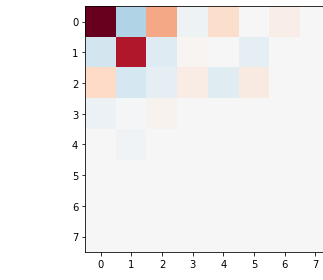

In [151]:
def spectrum(mb):
    return (
        MacroBlock.d8 @ (np.array(mb.array, dtype="int") - 128) @ MacroBlock.d8.T
    )
dct_obi_macro = spectrum(macroblocks[0][13, 25])
imshow(dct_obi_macro)
dct_obi_macro

After having applied the DCT we need to round the block values, so that we only keep the significant ones.

This is also where the quality factor will come into play through the quantization matrix.

array([[-100.,   30.,  -39.,    5.,  -12.,   -0.,   -2.,    0.],
       [  18.,  -80.,   13.,   -2.,   -0.,    3.,   -0.,   -0.],
       [ -20.,   17.,   10.,   -5.,    6.,   -3.,   -0.,    0.],
       [   6.,    2.,   -3.,   -0.,   -0.,   -0.,   -0.,    0.],
       [   0.,    2.,   -0.,   -0.,    0.,   -0.,    0.,    0.],
       [  -0.,    0.,   -0.,    0.,   -0.,   -0.,    0.,   -0.],
       [   0.,   -0.,   -0.,    0.,   -0.,    0.,   -0.,    0.],
       [  -0.,   -0.,   -0.,   -0.,   -0.,    0.,   -0.,   -0.]])

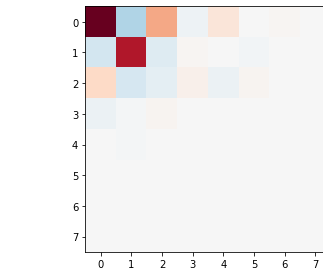

In [152]:
q_mat = np.array(
    [
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99],
    ]
)

def quantize(spectrum, q):
    alpha = 5000 / q if q < 50 else 200 - 2 * q
    qmat = MacroBlock.q_mat
    return np.round(spectrum / np.round((qmat * alpha + 50) / 100))

obi_macro_quant = quantize(dct_obi_macro, 95)

imshow(obi_macro_quant)
obi_macro_quant

We see that, compared to the state of the block after the DCT, we have lost some of the less importants coefficients.

Now we only have to remove the zero coefficients after the last non zero one, and put those coefficients in an array following a zig zag. It is done by the following code.

![](zigzag.png)


In [153]:
def zigzag(m):
    # Ugly zigzag line
    z = np.concatenate(
        [
            np.diagonal(m[::-1, :], i)[:: (1 - 2 * (i % 2))]
            for i in range(1 - m.shape[0], m.shape[0])
        ]
    )
    # Get a filter, make it so we only lose the last zeros from zigzag.
    if z[-1] == 0:
        f = z != 0
        if True in f:
            f[: len(f) - f[::-1].tolist().index(True) - 1] = True
        return z[f]
    else:
        return z
zigzag(obi_macro_quant)

array([-100.,   18.,   30.,  -39.,  -80.,  -20.,    6.,   17.,   13.,
          5.,  -12.,   -2.,   10.,    2.,    0.,   -0.,    2.,   -3.,
         -5.,   -0.,   -0.,   -2.,    3.,    6.,   -0.,   -0.,    0.,
          0.,   -0.,   -0.,   -0.,   -0.,   -0.,   -3.])

In [154]:
macroblocks[0][13, 25].coefs

array([-100.,   18.,   30.,  -39.,  -80.,  -20.,    6.,   17.,   13.,
          5.,  -12.,   -2.,   10.,    2.,    0.,   -0.,    2.,   -3.,
         -5.,   -0.,   -0.,   -2.,    3.,    6.,   -0.,   -0.,    0.,
          0.,   -0.,   -0.,   -0.,   -0.,   -0.,   -3.])

We find the same coefficients, that is reassuring. We can now display the compression ratio of this macro block.

In [155]:
macroblocks[0][13, 25].ratio

1.8823529411764706

## Greyscale decompression

Now that we can store the compressed version of our image, we would like to uncompress it to be able to see it.
The previous steps have to be done in reverse.
- Unzigzag the array back into a matrix
- Unquantize the matrix by multipliying by the quantizition matrix qmat (remember that is where information is lost)
- Applying the reverse DCT transform to find a macroblock of pixels.
- Rebuilding the image from the macroblocks
All of these steps are done in our code by the method `greyscale_uncompress`

In [156]:
image = MyImage.grayscale_uncompress(macroblocks, 95)

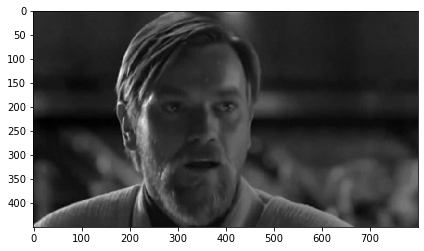

In [158]:
imshow(image.array)

## The problem of color
Now that greyscale compression is out of the way, we will explain the different ways in which an image with color channels can be compressed

## The RGB way
This way is the simplest. The idea is to do the compression on the three channels R, G, and B as if it were a grayscale image.

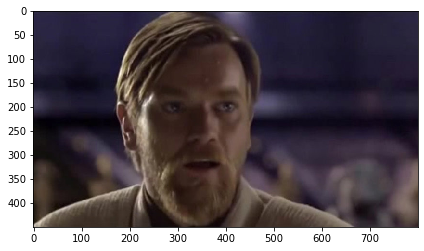

In [163]:
obi_col = MyImage.from_image("hello_there.jpg")
imshow(obi_col.array)

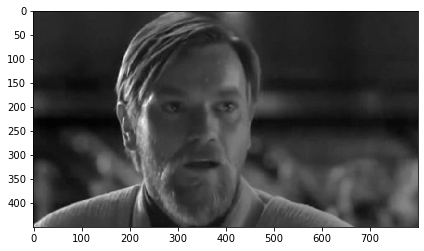

In [175]:
r = obi_col.channel0()
g = obi_col.channel1()
b = obi_col.channel2()
imshow(r.array)

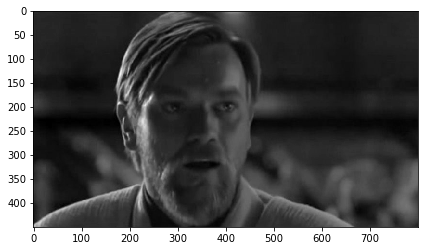

In [169]:
imshow(g.array)

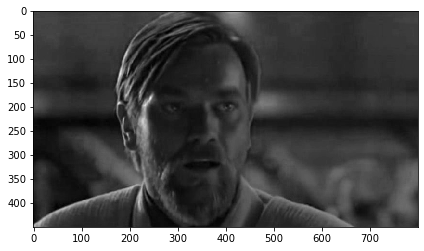

In [172]:
imshow(b.array)

In [185]:
obi_rgb_compressed_mb = [r.get_macro_arrays(95), g.get_macro_arrays(95), b.get_macro_arrays(95)]

In [224]:
def get_ratio(macro, i, j, r='4:4:4'):
    a = macro[0][0][i,j].ratio
    b = macro[1][0][i,j].ratio
    c = macro[2][0][i,j].ratio
    if r == '4:2:2':
        b *= 2
        c *= 2
    if r == '4:2:0':
        b *= 4
        c *= 4
    return (a + b + c) / 3

In [225]:
get_ratio(obi_rgb_compressed_mb, 13, 25)

1.8823529411764703

## The YUV way

RGB works, but is not that efficient, since the some of the same information basically has to be saved multiple times. 

The YUV color space allows us to have the data about the luminance of the image, and its color, in three separate channels.

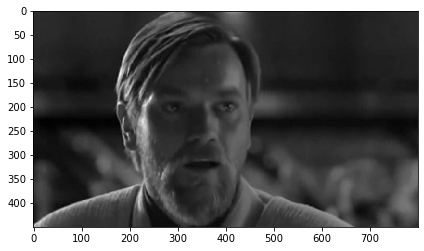

In [192]:
obi_yuv = MyImage.RGB_to_YUV(obi_col)
imshow(obi_yuv.channel0().array)

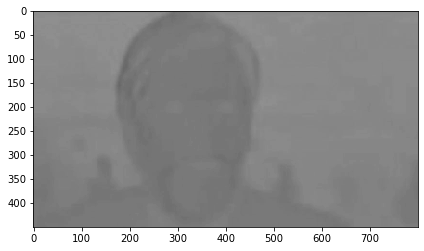

In [193]:
imshow(obi_yuv.channel1().array)

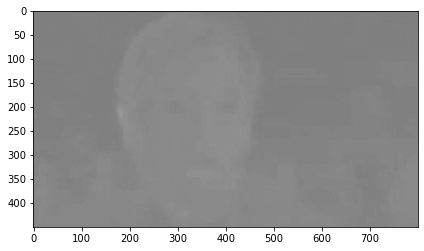

In [194]:
imshow(obi_yuv.channel2().array)

Clearly, in this color space, the information about the variation in intensity of the image is decorelated from the information about its color. The U and V channels are mostly solid color, which is very good for our compression algorithm.

They also appear to be less important than the Y channel. We will thus be able to shrink their quality without affecting the compression quality too much.

The steps are similar to the greyscale compression. Only, now, there is one special quantization matrix `quv_mat` for the U and V channels.

In [195]:
quv_mat = np.array(
    [
        [17, 18, 24, 47, 99, 99, 99, 99],
        [18, 21, 26, 66, 99, 99, 99, 99],
        [24, 26, 56, 99, 99, 99, 99, 99],
        [47, 66, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
    ]
)

In [226]:
obi_yuv_mb = MyImage.yuv_compress(obi_col, 95)

In [222]:
get_ratio(obi_yuv_mb, 13, 25)

26.22745098039216

In [206]:
obi_yuv_uncompress = MyImage.yuv_uncompress(obi_yuv_mb, 95)

(450, 800, 3)

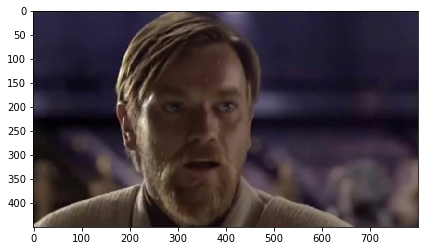

In [208]:
imshow(obi_yuv_uncompress.array)
obi_yuv_uncompress.array.shape

## Reducing the quality of U and V

We can further improve compression quality by downsampling U and V so that we only keep half or one quarter of the original information. This method is known as the 4:2:2 and 4:2:0 downsampling schemes.

In [210]:
obi_yuv_422 = MyImage.yuv_compress(obi_col, 95, '4:2:2')
obi_yuv_420 = MyImage.yuv_compress(obi_col, 95, '4:2:0')

In [227]:
get_ratio(obi_yuv_mb, 13, 25, '4:2:2')

51.827450980392165

In [230]:
get_ratio(obi_yuv_mb, 13, 25, '4:2:0')

103.02745098039215